In [ ]:
# %%

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import openap
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from openap import top
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

matplotlib.rc("font", size=12)
matplotlib.rc("font", family="Ubuntu")
matplotlib.rc("lines", linewidth=2, markersize=8)
matplotlib.rc("grid", color="darkgray", linestyle=":")

In [ ]:
# %%

ac = "a320"
wrap = openap.WRAP(ac)
aircraft = openap.prop.aircraft(ac)
max_range = wrap.cruise_range()["maximum"]
m_mtow = aircraft["limits"]["MTOW"]
oew = aircraft["limits"]["OEW"]

In [ ]:
# %%

dmin, dmax = 500, max_range
distance = list(range(dmin, int(dmax), 800))
mass = np.arange(0.7, 0.95, 0.05)

In [ ]:
# %%

flights = []

for d in distance:
    start_lon = -150
    start = (0, start_lon)
    end = (0, start_lon + d / 111.321)

    optimizer = top.CompleteFlight(ac, start, end, mass[3])

    flight = optimizer.trajectory(objective="fuel")
    n_nodes = max(30, int(d / 20))
    optimizer.setup_dc(nodes=n_nodes)
    if flight is None:
        continue

    flight = (
        flight.drop(["latitude", "longitude", "h"], axis=1)
        .assign(
            dist=lambda d: ((d.x - d.x.iloc[0]) / 1000).astype(int),
        )
        .drop(["x", "y"], axis=1)
        .assign(flight_id=lambda d: f"{int(round(d.dist.max(),-2))} km")
    )
    flights.append(flight)

flights = pd.concat(flights, ignore_index=True)

flights.to_csv("data/flights_different_distance.csv", index=False)

CasADi - 2024-09-12 17:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 3, col 0).") [.../casadi/core/oracle_function.cpp:377]


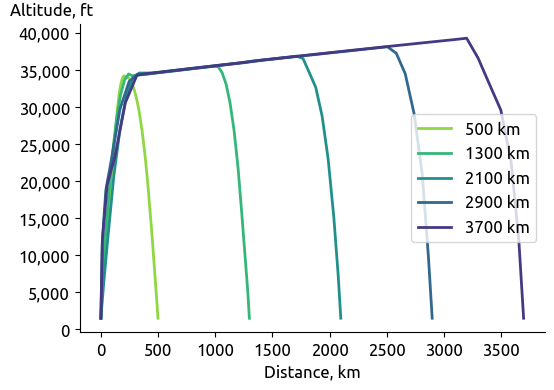

In [ ]:
# %%

flights = pd.read_csv("data/flights_different_distance.csv")

plt.figure(figsize=(6, 4))
ax = plt.gca()
sns.lineplot(
    data=flights, x="dist", y="altitude", hue="flight_id", palette="viridis_r", ax=ax
)
ax.set_xlabel("Distance, km")
ax.set_ylabel("Altitude, ft", rotation=0, ha="left")
ax.legend(loc="right")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_label_coords(-0.15, 1.02)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)


plt.savefig("figures/alt_vs_dist.png", bbox_inches="tight", dpi=100)

plt.show()

In [ ]:
# %%

flights = []

for m in mass:
    start_lon = -150
    start = (0, start_lon)
    d = distance[2]
    end = (0, start_lon + d / 111.321)

    optimizer = top.CompleteFlight(ac, start, end, m)

    flight = optimizer.trajectory(objective="fuel")
    n_nodes = max(30, int(d / 20))
    optimizer.setup_dc(nodes=n_nodes)
    if flight is None:
        continue

    flight = (
        flight.drop(["latitude", "longitude", "h"], axis=1)
        .assign(
            dist=lambda d: ((d.x - d.x.iloc[0]) / 1000).astype(int),
        )
        .drop(["x", "y"], axis=1)
        .assign(flight_id=f"{int(m*100)}% MTOW")
    )
    flights.append(flight)

flights = pd.concat(flights, ignore_index=True)

flights.to_csv("data/flights_different_mass.csv", index=False)

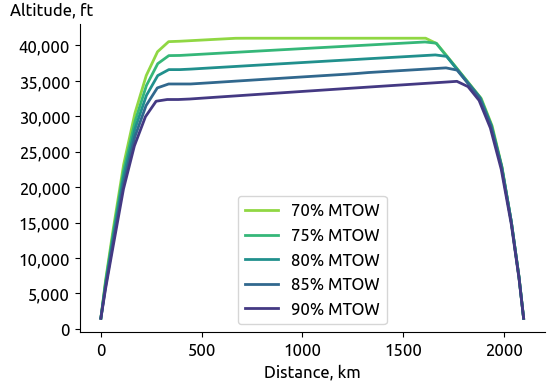

In [ ]:
# %%

flights = pd.read_csv("data/flights_different_mass.csv")

plt.figure(figsize=(6, 4))
ax = plt.gca()
sns.lineplot(
    data=flights, x="dist", y="altitude", hue="flight_id", palette="viridis_r", ax=ax
)
ax.set_xlabel("Distance, km")
ax.set_ylabel("Altitude, ft", rotation=0, ha="left")
ax.legend()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_label_coords(-0.15, 1.02)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)


plt.savefig("figures/alt_vs_mass.png", bbox_inches="tight", dpi=100)
plt.show()

In [ ]:
# %%

dataset_real = pd.read_csv("data/a320_estimate_real.csv")
dataset_opt = pd.read_csv("data/optimal/a320_optimal_df.csv").query("distance>500")
df_opensky = pd.read_csv("data/a320_estimate_opensky.csv").query(
    "mean_cruise_altitude<40500"
)

[x_opt, y_opt, c_opt] = [
    dataset_opt.distance,
    dataset_opt.mean_cruise_altitude,
    dataset_opt.takeoff_mass / 1000,
]
[x_real, y_real, c_real] = [
    dataset_real.distance,
    dataset_real.mean_cruise_altitude,
    dataset_real.takeoff_mass / 1000,
]
[x_pred, y_pred, c_pred] = [
    dataset_real.distance,
    dataset_real.mean_cruise_altitude,
    dataset_real.pred / 1000,
]
[x_osky, y_osky, c_osky] = [
    df_opensky.distance,
    df_opensky.mean_cruise_altitude,
    df_opensky.takeoff_mass / 1000,
]

norm = Normalize(
    vmin=oew * 1.2 / 1000,
    vmax=m_mtow / 1000,
)

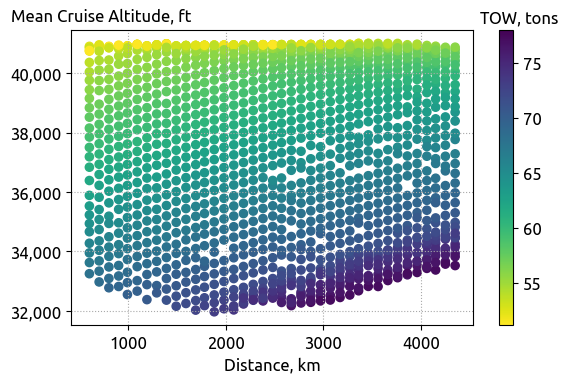

In [ ]:
# %%

plt.figure(figsize=(6, 4))
ax = plt.gca()

cmap = plt.get_cmap("viridis").reversed()
sm = ScalarMappable(norm=norm, cmap=cmap)

ax.scatter(x_opt, y_opt, c=sm.to_rgba(c_opt), s=35)

cbar = plt.colorbar(sm, ax=ax)
ax.text(4600, 41700, "TOW, tons")

ax.set_xlabel("Distance, km")
ax.set_ylabel("Mean Cruise Altitude, ft", rotation=0, ha="left")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.grid(True)

ax.yaxis.set_label_coords(-0.15, 1.02)
plt.tight_layout()

plt.savefig("figures/lookup.png", bbox_inches="tight", dpi=100)

plt.show()

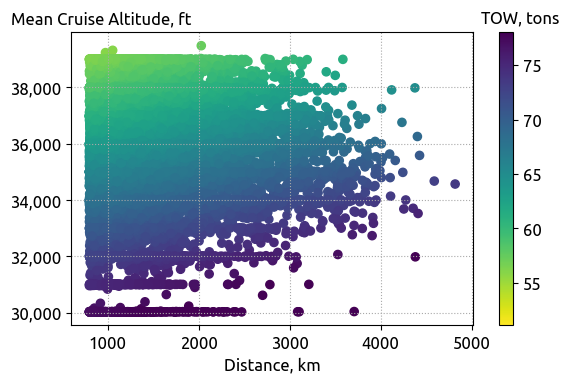

In [ ]:
# %%

plt.figure(figsize=(6, 4))
ax = plt.gca()

cmap = plt.get_cmap("viridis").reversed()
sm = ScalarMappable(norm=norm, cmap=cmap)

ax.scatter(x_osky, y_osky, c=sm.to_rgba(c_osky), s=35)

cbar = plt.colorbar(sm, ax=ax)
ax.text(5100, 40300, "TOW, tons")

ax.set_xlabel("Distance, km")
ax.set_ylabel("Mean Cruise Altitude, ft", rotation=0, ha="left")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.grid(True)
ax.yaxis.set_label_coords(-0.15, 1.02)
plt.tight_layout()

plt.savefig("figures/opensky.png", bbox_inches="tight", dpi=100)
plt.show()

In [ ]:
# %%

sample_df = pd.read_csv("data/sample_flight/flight-ac1-571.csv")
d = sample_df.distance.max()
start_lon = -150
m = dataset_real.query("fid== 'ac1-571'").pred.values[0] / m_mtow
start = (0, start_lon)
end = (0, start_lon + d / 111.321)

optimizer = top.CompleteFlight(ac, start, end, m)

n_nodes = max(30, int(d / 30))
optimizer.setup_dc(nodes=n_nodes)

flight = optimizer.trajectory(objective="fuel")

flight = (
    flight.drop(["latitude", "longitude", "h"], axis=1)
    .assign(
        distance=lambda d: ((d.x - d.x.iloc[0]) / 1000).astype(int),
    )
    .drop(["x", "y"], axis=1)
)
flight.to_csv("data/sample_flight/fuel_optimal_flight-ac1-571.csv")

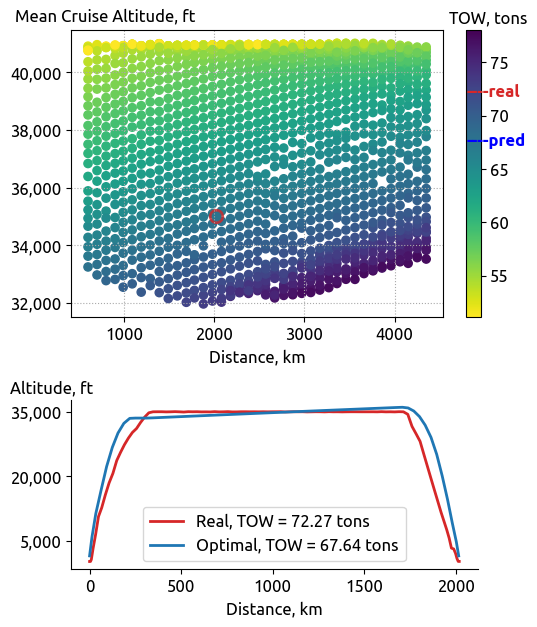

Sample flight dist = 2016.96
Mean cruise altitude = 35000.0
Sample TOW = 72.27 tons
Sample estimation error = 6.4%
Opt TOW = 67.64 tons


In [ ]:
# %%

m_actual = dataset_real.query("fid== 'ac1-571'").takeoff_mass.values[0] / 1000
m_pred = dataset_real.query("fid== 'ac1-571'").pred.values[0] / 1000
fig = plt.figure(figsize=(6, 7))
gs = matplotlib.gridspec.GridSpec(60, 40)
sm = ScalarMappable(norm=norm, cmap=cmap)
ax1 = fig.add_subplot(gs[0:32, 0:40])
ax2 = fig.add_subplot(gs[41:60, 0:35])
cmap = plt.get_cmap("viridis").reversed()
sm = ScalarMappable(norm=norm, cmap=cmap)
ax1.scatter(x_opt, y_opt, c=sm.to_rgba(c_opt), s=35)
ax1.scatter(
    dataset_real.query("fid== 'ac1-571'").distance.values[0],
    dataset_real.query("fid== 'ac1-571'").mean_cruise_altitude.values[0],
    s=100,
    c="tab:red",
    alpha=0.7,
)
ax1.scatter(
    dataset_real.query("fid== 'ac1-571'").distance.values[0],
    dataset_real.query("fid== 'ac1-571'").mean_cruise_altitude.values[0],
    c=sm.to_rgba(m_pred),
    s=35,
)

cbar = plt.colorbar(sm, ax=ax1)
cbar.ax.text(
    0.05,
    m_actual,
    "----real",
    va="center",
    ha="left",
    color="tab:red",
    fontsize=12,
    fontweight="bold",
    transform=cbar.ax.get_yaxis_transform(),
)
cbar.ax.text(
    0.05,
    m_pred,
    "----pred",
    va="center",
    ha="left",
    color="blue",
    fontsize=12,
    fontweight="bold",
    transform=cbar.ax.get_yaxis_transform(),
)


ax1.text(4600, 41700, "TOW, tons")

ax1.set_xlabel("Distance, km")
ax1.set_ylabel("Mean Cruise Altitude, ft", rotation=0, ha="left")
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax1.grid(True)
ax1.yaxis.set_label_coords(-0.15, 1.02)

sample_df = pd.read_csv("data/sample_flight/flight-ac1-571.csv")
flight = pd.read_csv("data/sample_flight/fuel_optimal_flight-ac1-571.csv")


ax2.plot(
    sample_df.distance,
    sample_df.altitude,
    color="tab:red",
    label=f"Real, TOW = {round(sample_df.gw_kg.max()/1000,2)} tons",
)

ax2.plot(
    flight.distance,
    flight.altitude,
    color="tab:blue",
    label=f"Optimal, TOW = {round(flight.mass.max()/1000,2)} tons",
)
ax2.set_yticks(np.arange(5000, 40000, step=15000))
ax2.set_xlabel("Distance, km")
ax2.set_ylabel("Altitude, ft", rotation=0, ha="left")
ax2.legend()

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.yaxis.set_label_coords(-0.15, 1.02)
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)

plt.tight_layout()

plt.savefig("figures/sample_real_in_lookup.png", bbox_inches="tight", dpi=100)
plt.show()
print("Sample flight dist = " + str(round(sample_df.distance.max(), 2)))
print(
    "Mean cruise altitude = "
    + str(
        round(dataset_real.query("fid== 'ac1-571'").mean_cruise_altitude.values[0], 2)
    )
)
print("Sample TOW = " + str(round(sample_df.gw_kg.max() / 1000, 2)) + " tons")
print(
    "Sample estimation error = "
    + str(round(dataset_real.query("fid== 'ac1-571'").error_percent.values[0], 2))
    + "%"
)
print("Opt TOW = " + str(round(flight.mass.max() / 1000, 2)) + " tons")

In [ ]:
# %%

def calculate_error_stats(df, pred_cols, error_cols, mape_cols):

    stats = []
    for pred_col, err_col, mape_col in zip(pred_cols, error_cols, mape_cols):
        mae = df[err_col].abs().mean()
        me = df[err_col].median()
        mape = df[mape_col].mean()
        std = df[err_col].std()
        rmse = root_mean_squared_error(df.takeoff_mass, df[pred_col].values)
        stats.append(
            f"RMSE:  {int(rmse)} kg\n"
            f"MAE:   {int(mae)} kg\n"
            f"MAPE:  {mape:.2f} % \n"
            f"ME:   {int(me):+05d} kg\n"
            f"STD:   {int(std)} kg\n"
        )
    return stats

In [ ]:
# %%

y = dataset_opt[["takeoff_mass"]].values
X_ad_real = dataset_real[["mean_cruise_altitude", "distance"]].values
X_ad = dataset_opt[["mean_cruise_altitude", "distance"]].values
X_atd_real = dataset_real[
    ["mean_cruise_altitude", "mean_cruise_tas", "distance"]
].values
X_atd = dataset_opt[["mean_cruise_altitude", "mean_cruise_tas", "distance"]].values
df = dataset_real[
    [
        "fid",
        "mean_cruise_altitude",
        "distance",
        "takeoff_mass",
        "mean_cruise_tas",
    ]
]

# Feature scaling
sc_ad = StandardScaler()
X_ad = sc_ad.fit_transform(X_ad)
X_ad_real = sc_ad.transform(X_ad_real)
sc_atd = StandardScaler()
X_atd = sc_atd.fit_transform(X_atd)
X_atd_real = sc_atd.transform(X_atd_real)
# Set up models and predictions
reg_ad = LinearRegression().fit(X_ad, y)
est_ad = HistGradientBoostingRegressor().fit(X_ad, y)
reg_atd = LinearRegression().fit(X_atd, y)
est_atd = HistGradientBoostingRegressor().fit(X_atd, y)

mult_pred_ad = reg_ad.predict(X_ad_real)
boost_pred_ad = est_ad.predict(X_ad_real)
mult_pred_atd = reg_atd.predict(X_atd_real)
boost_pred_atd = est_atd.predict(X_atd_real)

# Add predictions and errors to dataframe
df = (
    df.assign(
        boost_pred_ad=boost_pred_ad,
        mult_pred_ad=mult_pred_ad,
        boost_pred_atd=boost_pred_atd,
        mult_pred_atd=mult_pred_atd,
    )
    .assign(
        boost_error_ad=lambda x: x.boost_pred_ad - x.takeoff_mass,
        mult_error_ad=lambda x: x.mult_pred_ad - x.takeoff_mass,
        boost_error_atd=lambda x: x.boost_pred_atd - x.takeoff_mass,
        mult_error_atd=lambda x: x.mult_pred_atd - x.takeoff_mass,
    )
    .assign(
        boost_mape_ad=lambda x: abs(x.boost_error_ad / x.takeoff_mass) * 100,
        mult_mape_ad=lambda x: abs(x.mult_error_ad / x.takeoff_mass) * 100,
        boost_mape_atd=lambda x: abs(x.boost_error_atd / x.takeoff_mass) * 100,
        mult_mape_atd=lambda x: abs(x.mult_error_atd / x.takeoff_mass) * 100,
    )
)

pred_cols = [
    "mult_pred_ad",
    "boost_pred_ad",
    "mult_pred_atd",
    "boost_pred_atd",
]

error_columns = [
    "mult_error_ad",
    "boost_error_ad",
    "mult_error_atd",
    "boost_error_atd",
]

titles = [
    "a) 2D-Multilinear",
    "b) 2D-Boosting",
    "c) 3D-Multilinear",
    "d) 3D-Boosting",
]

mape_columns = [
    "mult_mape_ad",
    "boost_mape_ad",
    "mult_mape_atd",
    "boost_mape_atd",
]

stats = calculate_error_stats(df, pred_cols, error_columns, mape_columns)

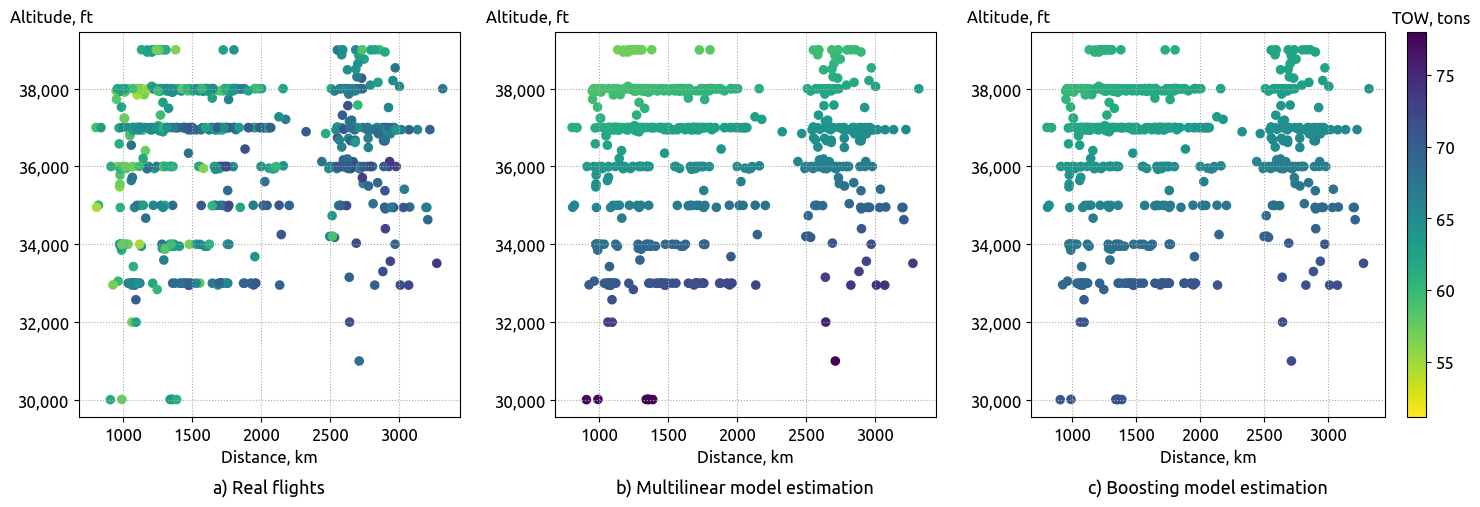

In [ ]:
# %%

fig = plt.figure(figsize=(18, 5))
gs = matplotlib.gridspec.GridSpec(1, 91)
ax1 = fig.add_subplot(gs[:, 0:25])
ax2 = fig.add_subplot(gs[:, 31:56])
ax3 = fig.add_subplot(gs[:, 62:91])
cmap = plt.get_cmap("viridis").reversed()
sm = ScalarMappable(norm=norm, cmap=cmap)

ax1.scatter(x_real, y_real, c=sm.to_rgba(c_real), s=35)
ax2.scatter(x_pred, y_pred, c=sm.to_rgba(c_pred), s=35)
ax3.scatter(x_pred, y_pred, c=sm.to_rgba(df.boost_pred_atd.values / 1000), s=35)

for ax in [ax1, ax2, ax3]:
    ax.grid(True)
    ax.set_xlabel("Distance, km")
    ax.set_ylabel("Altitude, ft", rotation=0, ha="left")
    ax.yaxis.set_label_coords(-0.18, 1.02)
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
    )

cbar = plt.colorbar(sm, ax=ax3)
ax3.text(3500, 39700, "TOW, tons")

ax1.set_title("a) Real flights", fontsize=13, y=-0.22)
ax2.set_title("b) Multilinear model estimation", fontsize=13, y=-0.22)
ax3.set_title("c) Boosting model estimation", fontsize=13, y=-0.22)

plt.tight_layout()

plt.savefig("figures/real_vs_opt.png", bbox_inches="tight", dpi=100)
plt.show()

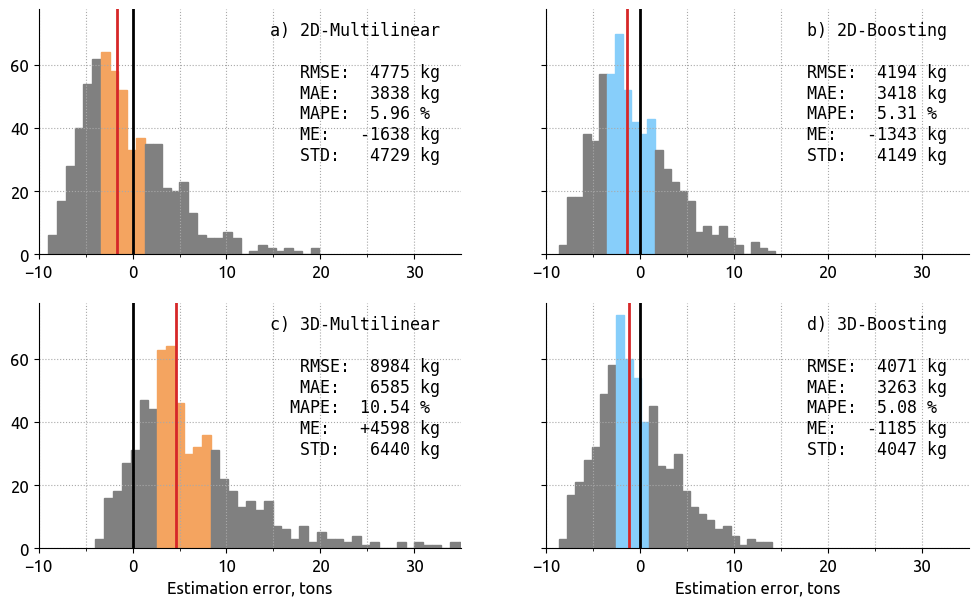

In [ ]:
# %%

def plot_histograms(df, stats, error_columns, mape_columns, titles, file_name=None):
    """Plot histograms with error statistics."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharey=True)
    axes = axes.flatten()

    for i, (ax, stat, col, title) in enumerate(zip(axes, stats, error_columns, titles)):

        Q1 = np.percentile(df[col] / 1000, 25)
        Q3 = np.percentile(df[col] / 1000, 75)

        counts, edges, patches = ax.hist(
            df[col] / 1000,
            bins=int(df[col].std() / 150),
            edgecolor="gray",
            color="tab:blue",
        )

        for j, patch in enumerate(patches):
            if edges[j] >= Q1 and edges[j + 1] <= Q3:
                if "mult" in col:
                    c = "sandybrown"
                else:
                    c = "lightskyblue"
            else:
                c = "gray"
            patch.set_facecolor(c)
            patch.set_edgecolor(c)

        ax.axvline(0, color="k", lw=2)
        ax.axvline(df[col].median() / 1000, color="tab:red", linewidth=2)
        # ax.set_ylabel("Flights", rotation=0, ha="left")
        ax.yaxis.set_label_coords(-0.095, 1.02)
        ax.set_xlabel("Estimation error, tons")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_yticks(np.arange(0, 70, 20))
        ax.set_xticks(np.arange(-10, 35, 5), minor=True)
        # ax.set_ylim(0, 70)
        ax.set_xlim(-10, 35)
        ax.grid(which="both")
        # ax.set_xlim(-10_000,25_000)

        if i < 2:
            ax.set_xlabel(None)

        stat = title + "\n\n" + stat

        ax.text(
            0.95,
            0.95,
            stat,
            ha="right",
            transform=ax.transAxes,
            fontsize=12,
            fontfamily="monospace",
            verticalalignment="top",
        )

    if file_name is not None:
        plt.savefig(file_name + ".pdf", bbox_inches="tight")
        plt.savefig(file_name + ".png", bbox_inches="tight", dpi=100)

    plt.show()


plot_histograms(
    df,
    stats,
    error_columns,
    mape_columns,
    titles,
    "figures/compare_models_err_hist",
)

In [ ]:
# %%

def plot_boxplots(df, error_columns, file_name=None):
    df_melted = df.melt(
        value_vars=error_columns,
        var_name="Model",
        value_name="Estimation Error",
    )

    df_melted["Model Type"] = df_melted["Model"].apply(
        lambda x: "LR" if "mult" in x else "HGBT"
    )
    df_melted["Feature Set"] = df_melted["Model"].apply(
        lambda x: ("3D" if "_atd" in x else "2D")
    )

    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(
        x="Feature Set",
        y="Estimation Error",
        hue="Model Type",
        palette=["sandybrown", "lightskyblue"],
        data=df_melted,
        gap=0.05,
    )
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["LR", "HGBT"])
    ax.axhline(0, color=".3", dashes=(2, 2), alpha=0.6)
    ax.set_ylabel("Error, tons", rotation=0, ha="left")
    ax.yaxis.set_label_coords(-0.095, 1.04)
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x / 1000), ","))
    )
    ax.set(xlabel=None)
    sns.despine(offset=10, trim=True)
    if file_name is not None:
        plt.savefig(file_name + ".pdf", bbox_inches="tight")
        plt.savefig(file_name + ".png", bbox_inches="tight", dpi=100)

    plt.show()


# plot_boxplots(df, error_columns, "figures/compare_models_boxplot")

In [ ]:
# %%

tabl_alt_err = []
for i in list(range(39, 31, -1)):
    alt = i * 1000
    alt_min = alt - 500
    alt_max = alt + 500

    if i == 39:
        alt_max = 50_000
    elif i == 32:
        alt_min = 0

    me = dataset_real.query("@alt_max > mean_cruise_altitude > @alt_min").error.median()
    mae = (
        dataset_real.query("@alt_max > mean_cruise_altitude > @alt_min")
        .error.abs()
        .mean()
    )
    rmse = root_mean_squared_error(
        dataset_real.query("@alt_max > mean_cruise_altitude > @alt_min").takeoff_mass,
        dataset_real.query("@alt_max > mean_cruise_altitude > @alt_min").pred.values,
    )
    mape = round(
        dataset_real.query(
            "@alt_max > mean_cruise_altitude > @alt_min"
        ).error_percent.mean(),
        2,
    )
    num_fli = len(dataset_real.query("@alt_max > mean_cruise_altitude > @alt_min"))
    tabl_alt_err.append(
        {
            "# of flights": num_fli,
            "separator0": "&",
            "alt, ft": f"{alt:,}".replace(",", " "),
            "separator1": "&",
            "me, kg": f"{int(me):,}".replace(",", " "),
            "separator2": "&",
            "mae, kg": f"{mae.astype(int):,}".replace(",", " "),
            "separator3": "&",
            "rmse, kg": f"{rmse.astype(int):,}".replace(",", " "),
            "separator4": "&",
            "mape %": f"{mape:0.2f}" + "\%",
            "separator5": "\\\\",
        }
    )
df_alt_err = pd.DataFrame.from_dict(tabl_alt_err)
df_alt_err = df_alt_err.set_index(["# of flights"])
df_alt_err

,separator0,"alt, ft",separator1,"me, kg",separator2,"mae, kg",separator3,"rmse, kg",separator4,mape %,separator5
# of flights,,,,,,,,,,,
35,&,39 000,&,-4 762,&,3 961,&,4 449,&,6.27\%,\\
160,&,38 000,&,-2 640,&,3 178,&,3 686,&,5.01\%,\\
181,&,37 000,&,-3 427,&,3 746,&,4 384,&,5.58\%,\\
97,&,36 000,&,-1 114,&,3 475,&,4 083,&,5.28\%,\\
49,&,35 000,&,-639,&,2 715,&,3 458,&,4.20\%,\\
48,&,34 000,&,5 088,&,5 585,&,6 596,&,9.16\%,\\
57,&,33 000,&,3 053,&,4 113,&,5 091,&,6.36\%,\\
11,&,32 000,&,15 131,&,14 232,&,14 878,&,23.27\%,\\


In [ ]:
# %%

import xarray as xr

wind = xr.open_dataset(
    f"data/temperature/adaptor.mars.internal-1714739498.5300884-18127-11-2ef1ac2f-16ab-4756-96c1-07f1e9f761d7.grib",
    engine="cfgrib",
)

df_wind = wind.to_dataframe().reset_index().query("time.dt.hour==0")

df_wind = df_wind.assign(
    altitude=lambda x: (1 - (x.isobaricInhPa / 1013.25) ** 0.190284) * 145366.45
)
df_wind = df_wind.query("altitude<60000")

Ignoring index file 'data/temperature/adaptor.mars.internal-1714739498.5300884-18127-11-2ef1ac2f-16ab-4756-96c1-07f1e9f761d7.grib.923a8.idx' incompatible with GRIB file


In [ ]:
# %%

h = np.arange(0, 18000, 50)
p, rho, temp = openap.aero.atmos(h)

a, b, d = [85.46369268, -0.00017235, 213.31449979]
temp_exp = a * np.exp(h * b) + d

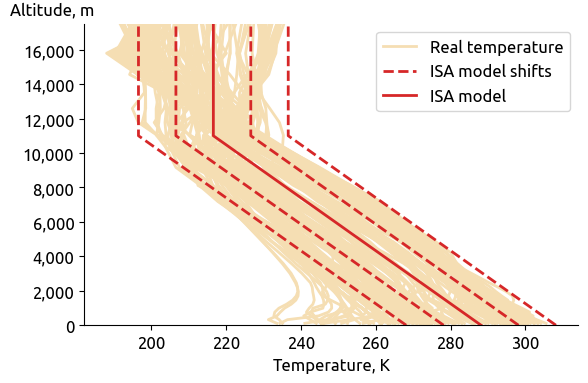

In [ ]:
# %%

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

for i in range(-90, 90, 10):
    for j in range(-180, 180, 20):
        ax.plot(
            df_wind.query("latitude == @i and longitude == @j").t,
            df_wind.query("latitude == @i and longitude == @j").altitude * 0.3048,
            "wheat",
            label="Real temperature" if i == 0 and j == 0 else "_nolegend_",
        )
for i in range(-20, 30, 10):
    if i == 0:
        ax.plot(temp + i, h, "tab:red", label="ISA model")
    else:
        ax.plot(
            temp + i,
            h,
            "tab:red",
            linestyle="dashed",
            label="ISA model shifts" if i == -10 else "_nolegend_",
        )

ax.set_ylim(0, 17500)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.set_xlabel("Temperature, K")
ax.set_ylabel("Altitude, m", rotation=0, ha="left")
ax.legend()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_label_coords(-0.15, 1.02)
plt.tight_layout()

plt.savefig("figures/temperatures.png", bbox_inches="tight", dpi=100)
plt.show()

In [ ]:
# %%

sample_df = pd.read_csv("data/sample_flight/flight-ac1-571.csv")
flight = pd.read_csv("data/sample_flight/fuel_optimal_flight-ac1-571.csv")

In [ ]:
# %%

d = sample_df.distance.max()
start_lon = -150
m = sample_df.gw_kg.max() / m_mtow
start = (0, start_lon)
end = (0, start_lon + d / 111.321)

optimizer = top.CompleteFlight(ac, start, end, m)
optimizer.setup_dc(nodes=94)

flight1 = optimizer.trajectory(objective="fuel")

flight1 = (
    flight1.drop(["latitude", "longitude", "h"], axis=1)
    .assign(
        distance=lambda d: ((d.x - d.x.iloc[0]) / 1000).astype(int),
    )
    .drop(["x", "y"], axis=1)
)
flight1.to_csv("data/sample_flight/fuel_optimal_flight_real_tow-ac1-571.csv")

In [ ]:
# %%

flight1 = pd.read_csv("data/sample_flight/fuel_optimal_flight_real_tow-ac1-571.csv")
coefs = pd.read_csv("lin_two_feat_coefs.csv")

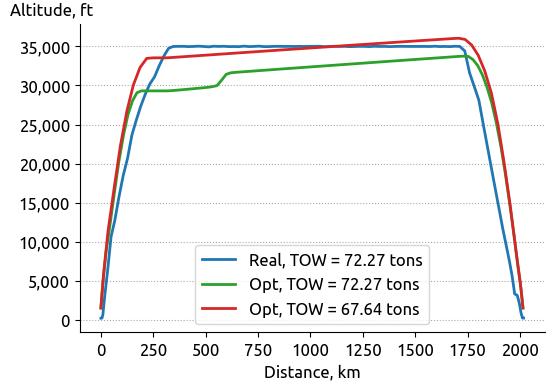

In [ ]:
# %%

plt.figure(figsize=(6, 4))
ax = plt.subplot()
ax.plot(
    sample_df.distance,
    sample_df.altitude,
    "tab:blue",
    label=f"Real, TOW = {round(sample_df.gw_kg.max()/1000,2)} tons",
)
ax.plot(
    flight1.distance,
    flight1.altitude,
    "tab:green",
    label=f"Opt, TOW = {round(flight1.mass.max()/1000,2)} tons",
)
ax.plot(
    flight.distance,
    flight.altitude,
    "tab:red",
    label=f"Opt, TOW = {round(flight.mass.max()/1000,2)} tons",
)
plt.legend()


ax.set_xlabel("Distance, km")
ax.set_ylabel("Altitude, ft", rotation=0, ha="left")
# ax.legend(loc="right")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_label_coords(-0.15, 1.02)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
plt.grid(axis="y")

plt.savefig("figures/roo.png", bbox_inches="tight", dpi=100)

plt.show()

In [ ]:
# %%

alt_real = sample_df.query("-500<roc<50 and altitude>30000").altitude.mean().astype(int)
tas_real = sample_df.query("-500<roc<50 and altitude>30000").tas.mean().astype(int)
real_params = [
    f"{alt_real:,}".replace(",", " "),
    f"{tas_real:,}".replace(",", " "),
    f"{int(sample_df.distance.max()):,}".replace(",", " "),
    f"{int(sample_df.ts.max() / 60):,}".replace(",", " "),
    f"{int(sample_df.gw_kg.min()):,}".replace(",", " "),
    f"{int(sample_df.gw_kg.max()):,}".replace(",", " "),
    f"{int(sample_df.gw_kg.max() - sample_df.gw_kg.min()):,}".replace(",", " "),
]
alt_opt1 = flight.query("-500<vertical_rate<50").altitude.mean().astype(int)
tas_opt1 = flight.query("-500<vertical_rate<50").tas.mean().astype(int)
opt1_params = [
    f"{alt_opt1:,}".replace(",", " "),
    f"{tas_opt1:,}".replace(",", " "),
    f"{int(flight.distance.max()):,}".replace(",", " "),
    f"{int(flight.ts.max() / 60):,}".replace(",", " "),
    f"{int(flight.mass.min()):,}".replace(",", " "),
    f"{int(flight.mass.max()):,}".replace(",", " "),
    f"{int(flight.mass.max() - flight.mass.min()):,}".replace(",", " "),
]

alt_opt2 = flight.query("-500<vertical_rate<50").altitude.mean().astype(int)
tas_opt2 = flight.query("-500<vertical_rate<50").tas.mean().astype(int)
opt2_params = [
    f"{alt_opt2:,}".replace(",", " "),
    f"{tas_opt2:,}".replace(",", " "),
    f"{int(flight1.distance.max()):,}".replace(",", " "),
    f"{int(flight1.ts.max() / 60):,}".replace(",", " "),
    f"{int(flight1.mass.min()):,}".replace(",", " "),
    f"{int(flight1.mass.max()):,}".replace(",", " "),
    f"{int(flight1.mass.max() - flight1.mass.min()):,}".replace(",", " "),
]
df_roo = pd.DataFrame(
    np.array(["&"] * 7).reshape(7, 1),
    columns=["separator0"],
    index=[
        "Mean cruise altitude (ft) ",
        "Mean cruise TAS (kt)",
        "Air distance (km)",
        "Flight time (min)",
        "Take-off mass (kg) ",
        "Landing mass (kg)",
        "Fuel spent (kg)",
    ],
).assign(
    real=real_params,
    separator1=["&"] * 7,
    opt_real_tow=opt2_params,
    separator2=["&"] * 7,
    opt_opt_tow=opt1_params,
    separator3=[r"\\"] * 7,
)
# df_roo = df_roo.assign(

#     opt_real_tow=lambda x: round(x.opt_real_tow, 0).astype(int),
#     opt_opt_tow=lambda x: round(x.opt_opt_tow, 0).astype(int),
# )
df_roo

,separator0,real,separator1,opt_real_tow,separator2,opt_opt_tow,separator3
Mean cruise altitude (ft),&,35 000,&,34 754,&,34 754,\\
Mean cruise TAS (kt),&,443,&,459,&,459,\\
Air distance (km),&,2 016,&,2 014,&,2 014,\\
Flight time (min),&,173,&,147,&,146,\\
Take-off mass (kg),&,64 936,&,64 663,&,60 380,\\
Landing mass (kg),&,72 266,&,72 266,&,67 639,\\
Fuel spent (kg),&,7 330,&,7 603,&,7 259,\\
